In [2]:
!pip install --upgrade scikit-learn xgboost imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 86.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Preprocessing and Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline # Use the imblearn pipeline!

# The SMOTE technique for handling imbalance
from imblearn.over_sampling import SMOTE

# Model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTENC


# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Set visualization style
sns.set_style("whitegrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection-in-transactions-dataset/fraud_detection.csv


# 1. Exploratory Data Analysis

### Basic Data Information

In [4]:
# Check basic info for the dataset
# Load the dataset
DATA_PATH = "/kaggle/input/fraud-detection-in-transactions-dataset/fraud_detection.csv"
df = pd.read_csv(DATA_PATH)

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Display dataset info (columns, data types, null values)
print("\nDataset Information:")
df.info()

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
display(df.describe())

First 5 rows of the dataset:


,transaction_id,amount,merchant_type,device_type,label
0,1,46.93,travel,tablet,0
1,2,301.01,groceries,desktop,0
2,3,131.67,others,tablet,0
3,4,91.29,electronics,desktop,0
4,5,16.96,others,mobile,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB

Summary Statistics:


,transaction_id,amount,label
count,1000.000000,1000.000000,1000.000000
mean,500.500000,97.250560,0.050000
std,288.819436,97.250965,0.218054
min,1.000000,0.460000,0.000000
25%,250.750000,26.915000,0.000000
50%,500.500000,68.680000,0.000000
75%,750.250000,136.385000,0.000000
max,1000.000000,817.240000,1.000000


In [5]:
# Check null value
df.isnull().sum()

transaction_id    0
amount            0
merchant_type     0
device_type       0
label             0
dtype: int64

In [6]:
# Check duplicate value
df.duplicated().sum()

0

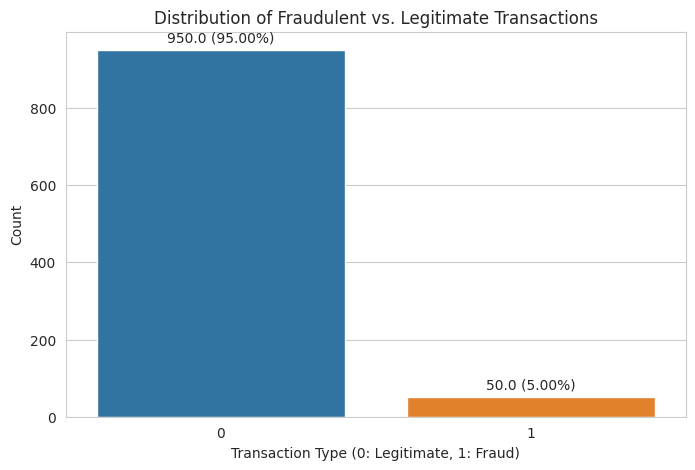

In [7]:
# --- Target Variable Distribution ---
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.xlabel('Transaction Type (0: Legitimate, 1: Fraud)')
plt.ylabel('Count')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

### Univariate Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


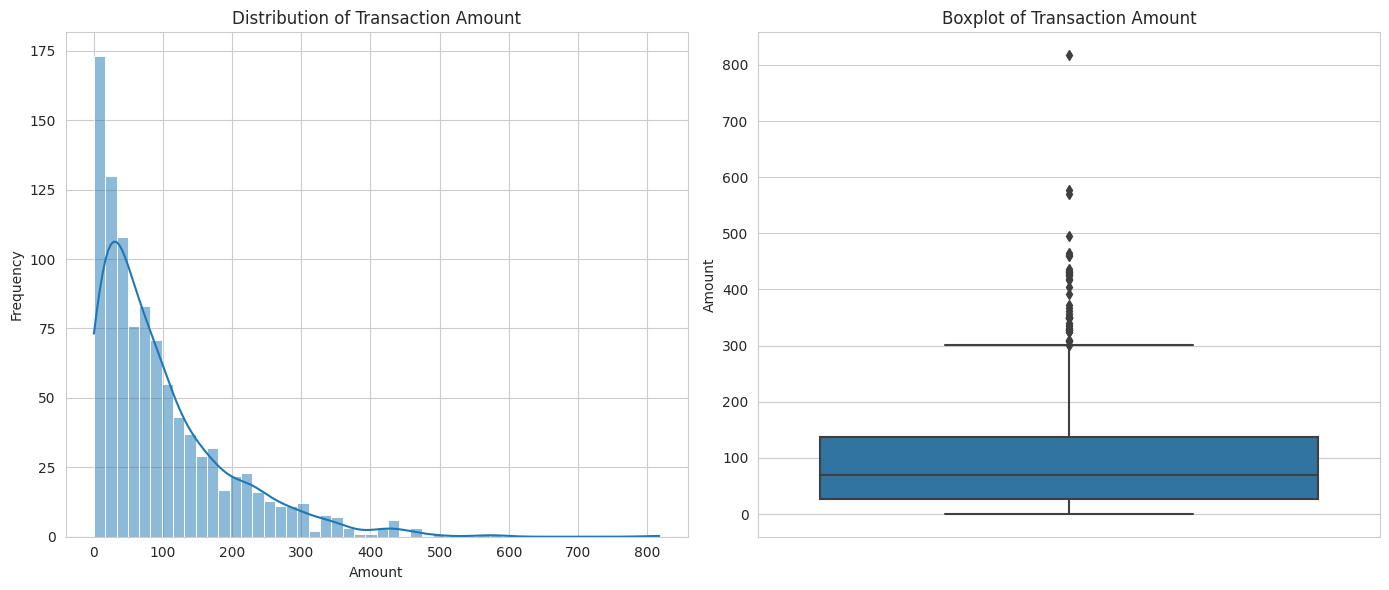

In [8]:
# --- Analysis of Transaction Amount ---
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df['amount'])
plt.title('Boxplot of Transaction Amount')
plt.ylabel('Amount')

plt.tight_layout()
plt.show()

# --- Key Insights ---
# Look for skewness in the distribution.
# Are there significant outliers?

In [9]:
# Checking skewness
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")


📈 Skewness Check:
label             4.135689
amount            1.867839
transaction_id    0.000000
dtype: float64

📌 Recommendation:
⚠️ label is highly skewed (skew=4.14). Suggest: Apply log or sqrt transform.
⚠️ amount is highly skewed (skew=1.87). Suggest: Apply log or sqrt transform.
✅ transaction_id is fairly symmetric (skew=0.00). No action needed.


Based on the chart above, we can see that :
- the data is skewed to the right, which mean it's skewed positiviely
- on the boxplot, there are quite significant outlier, ranging from amount of 300 to 800~ 

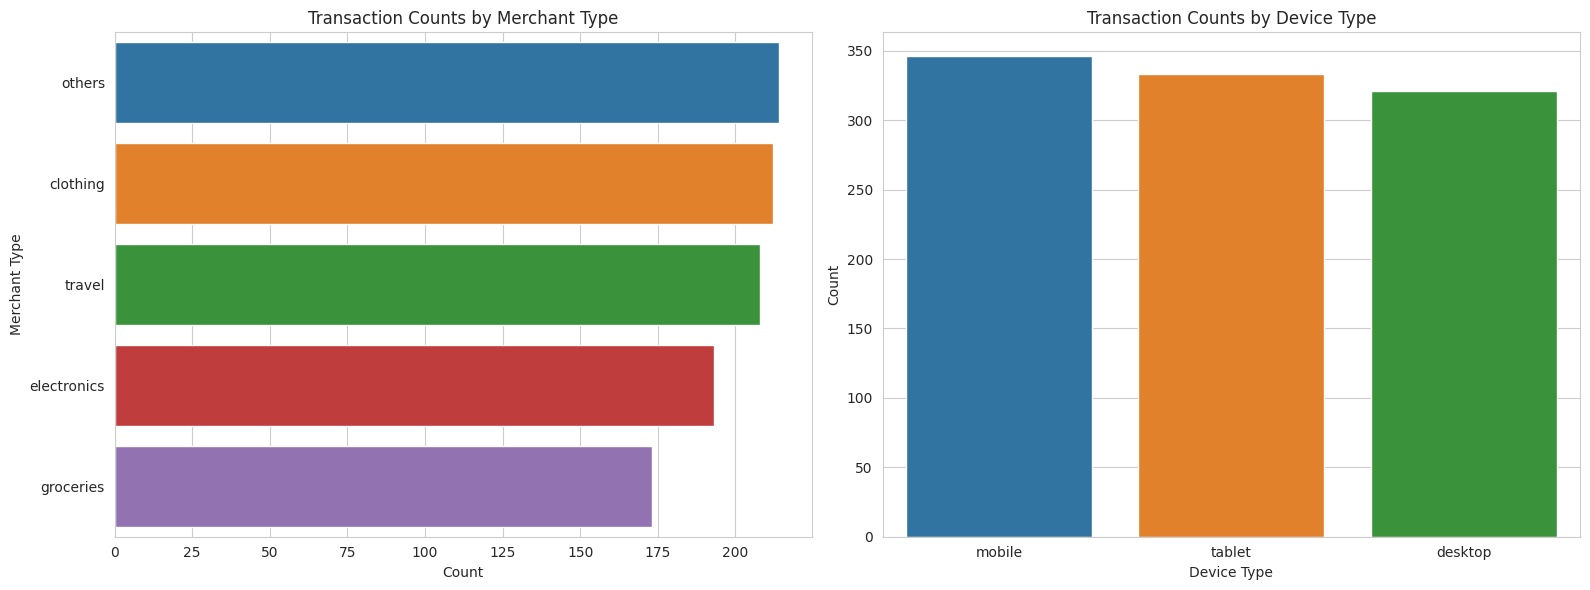

In [10]:
# --- Analysis of Categorical Features ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Merchant Type
sns.countplot(y='merchant_type', data=df, ax=axes[0], order=df['merchant_type'].value_counts().index)
axes[0].set_title('Transaction Counts by Merchant Type')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Merchant Type')

# Device Type
sns.countplot(x='device_type', data=df, ax=axes[1], order=df['device_type'].value_counts().index)
axes[1].set_title('Transaction Counts by Device Type')
axes[1].set_xlabel('Device Type')
axes[1].set_ylabel('Count')


plt.tight_layout()
plt.show()

# --- Key Insights ---
# Which categories are most common?
# Is the distribution even or skewed towards certain categories?

We can see that from this transaction data, most transaction coming from others merchant_type, while the groceries coming on the last. Based on device_type, user is coming from the most from mobile device, but not significanty different from other device type.

### Bivariate Analysis (Feature vs. Target)

amount vs label

In [11]:
# df.groupby(["label","merchant_type","device_type"])["amount"].agg(['min', 'max'])
df.groupby("label")["amount"].agg(['min', 'max'])

,min,max
label,,
0,0.46,817.24
1,3.76,431.55


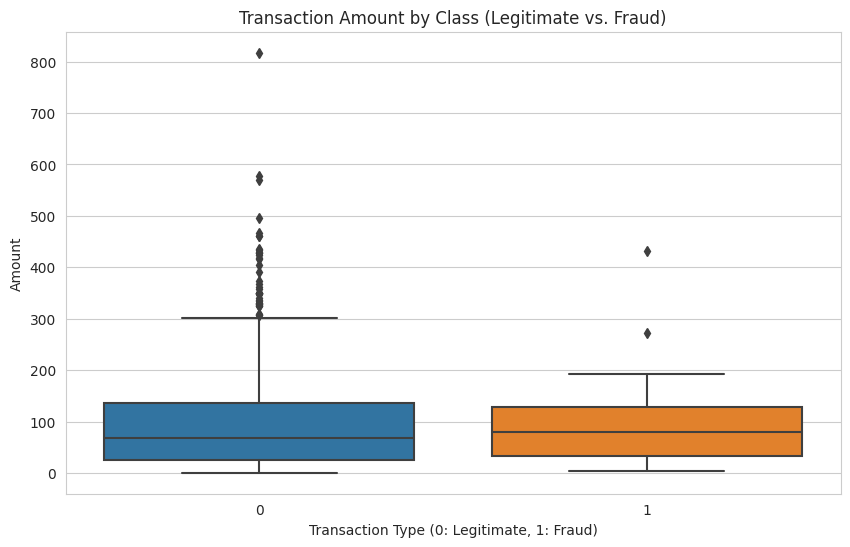

In [12]:
# --- Amount vs. Fraud Label ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='amount', data=df)
plt.title('Transaction Amount by Class (Legitimate vs. Fraud)')
plt.xlabel('Transaction Type (0: Legitimate, 1: Fraud)')
plt.ylabel('Amount')
# Use a log scale if the difference is hard to see
# plt.yscale('log')
plt.show()


# --- Key Insights ---
# Do fraudulent transactions tend to have higher or lower amounts?
# Is there a clear separation in the distributions?

Fraud Rate by Merchant Type:
 label                 0         1
merchant_type                    
others         0.925234  0.074766
electronics    0.943005  0.056995
clothing       0.957547  0.042453
travel         0.961538  0.038462
groceries      0.965318  0.034682

Fraud Rate by Device Type:
 label               0         1
device_type                    
mobile       0.945087  0.054913
tablet       0.948949  0.051051
desktop      0.956386  0.043614


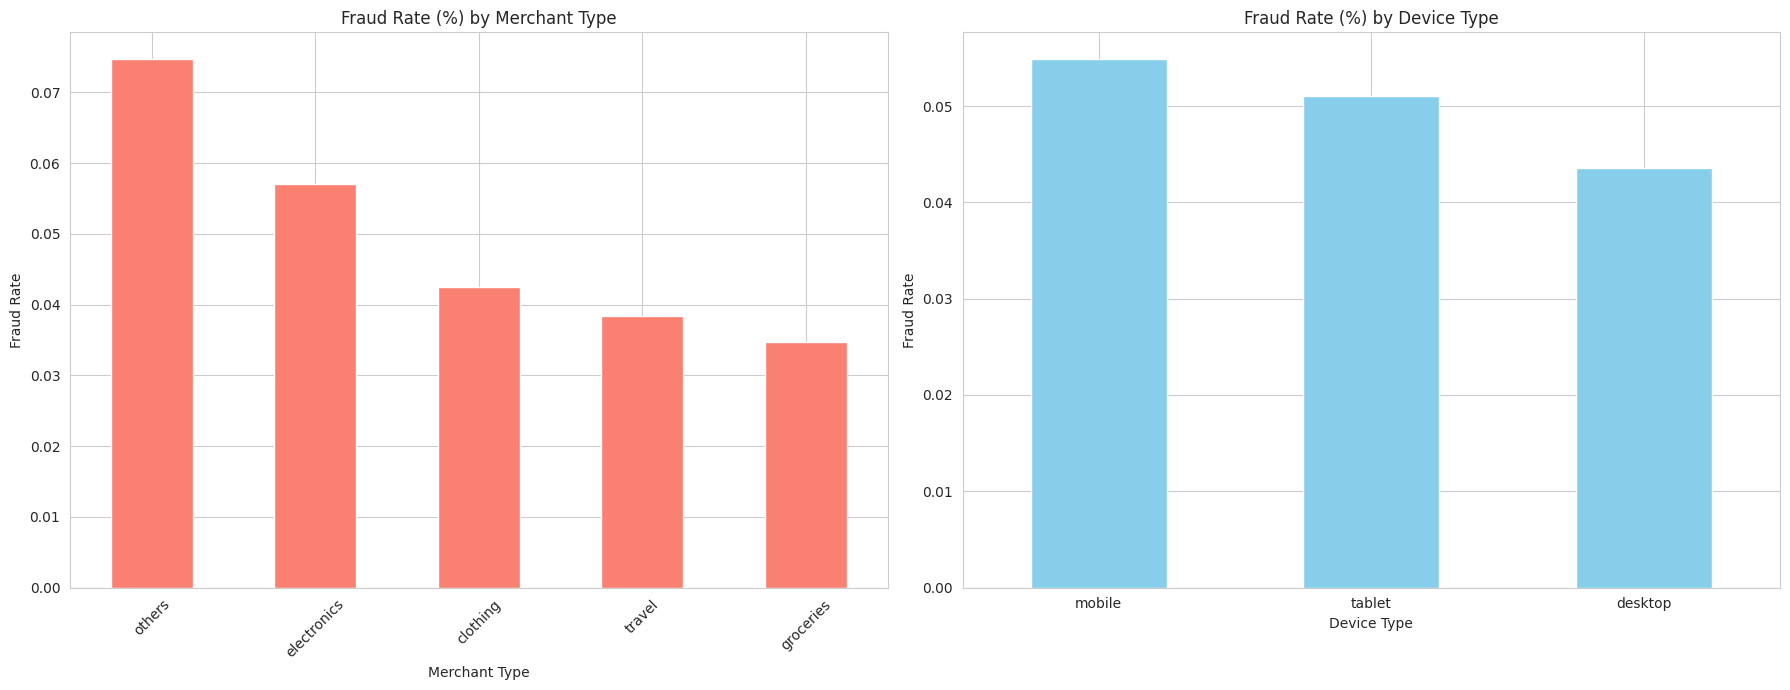

In [13]:
# --- Categorical Features vs. Fraud Label ---

# Calculate fraud rate by merchant type
fraud_rate_merchant = df.groupby('merchant_type')['label'].value_counts(normalize=True).unstack().fillna(0)
fraud_rate_merchant = fraud_rate_merchant.sort_values(by=1, ascending=False)
print("Fraud Rate by Merchant Type:\n", fraud_rate_merchant)

# Calculate fraud rate by device type
fraud_rate_device = df.groupby('device_type')['label'].value_counts(normalize=True).unstack().fillna(0)
fraud_rate_device = fraud_rate_device.sort_values(by=1, ascending=False)
print("\nFraud Rate by Device Type:\n", fraud_rate_device)

# Plotting the fraud rates
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

fraud_rate_merchant[1].plot(kind='bar', ax=axes[0], color='salmon')
axes[0].set_title('Fraud Rate (%) by Merchant Type')
axes[0].set_ylabel('Fraud Rate')
axes[0].set_xlabel('Merchant Type')
axes[0].tick_params(axis='x', rotation=45)

fraud_rate_device[1].plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Fraud Rate (%) by Device Type')
axes[1].set_ylabel('Fraud Rate')
axes[1].set_xlabel('Device Type')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# --- Key Insights ---
# Are certain merchant or device types more associated with fraud?
# These features are likely strong predictors if the fraud rate varies significantly across categories.

Based on chart above, we can see that most of fraud transaction coming from others merchant_type and mobile device_type. Since the data is imbalanced, we will use SMOTE to add synthetic sample on the next step.

# 2. Preprocessing, Feature Engineering & Splitting

### Drop Unnecesary Column

In [14]:
# --- Define Features and Target ---
X = df.drop(['label', 'transaction_id'], axis=1)
y = df['label']

### Define Preprocessing Steps

In [15]:
# --- Identify Feature Types ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['amount']
Categorical features: ['merchant_type', 'device_type']


In [16]:
# --- Define Advanced Preprocessing Steps ---

# Create a pipeline for numerical features: apply log transform, then scale
log_scaler_pipeline = ImbPipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

In [17]:
# Create the master preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', log_scaler_pipeline, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

### Split & Tranform The Data

In [18]:
# Splitting the data into training & test data
# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 3)
Testing set shape: (200, 3)


# 3. Finding the Best Model with GridSearchCV

### Define & Setup full pipeline for GridSearchCV

In [19]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

In [20]:
# --- Define the "Grid" of Parameters to Test ---
# We'll test a few key hyperparameters for XGBoost.
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 1.0] # Fraction of samples to be used for fitting the individual base learners.
}

In [21]:
# --- Set up and Run GridSearchCV ---
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1', # We care most about the F1-score for the fraud class
    cv=3,         # 3-fold cross-validation
    n_jobs=-1,    # Use all available CPU cores
    verbose=2     # Show progress
)

print("--- Starting GridSearchCV to find the best XGBoost model ---")
grid_search.fit(X_train, y_train)

--- Starting GridSearchCV to find the best XGBoost model ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['merchant_type',
                                                                          'device_type'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        XGBCl...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.7, 1.0]},
             scoring='f1', verbose=2)

### Show GridSearchCV Result

In [22]:
# --- Print the Results ---
print("\n--- GridSearchCV Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy from cross-validation: {grid_search.best_score_:.4f}")


--- GridSearchCV Complete ---
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.7}
Best accuracy from cross-validation: 0.0546


# 4. XGBoost Model Evaluation

In [23]:
# --- The best model is ready to use ---
best_pipeline = grid_search.best_estimator_

In [24]:
# --- Evaluate the final, tuned model on the test set ---
print("\n--- Final Evaluation on the Hold-Out Test Set ---")
y_pred = best_pipeline.predict(X_test)


--- Final Evaluation on the Hold-Out Test Set ---


In [25]:
# --- Generate and print the Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       190
           1       0.03      0.10      0.04        10

    accuracy                           0.79       200
   macro avg       0.49      0.46      0.46       200
weighted avg       0.90      0.79      0.84       200



Confusion Matrix:


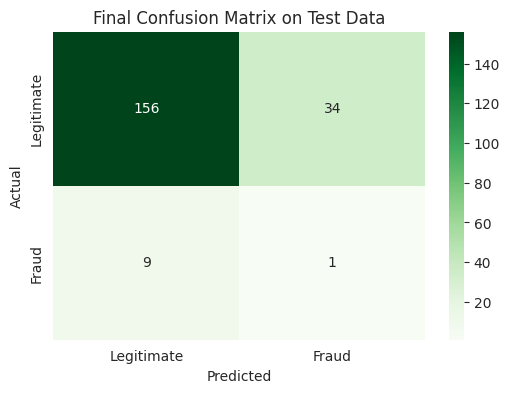

In [26]:
# --- Generate and Plot the Confusion Matrix ---
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Final Confusion Matrix on Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 5. Comparing with other model

In [73]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True), # probability=True is needed for ROC AUC
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


--- Starting Model Comparison with SMOTE and Detailed Reporting ---

         Training and Evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.61      0.75       190
           1       0.06      0.50      0.11        10

    accuracy                           0.60       200
   macro avg       0.51      0.56      0.43       200
weighted avg       0.91      0.60      0.71       200

Confusion Matrix:


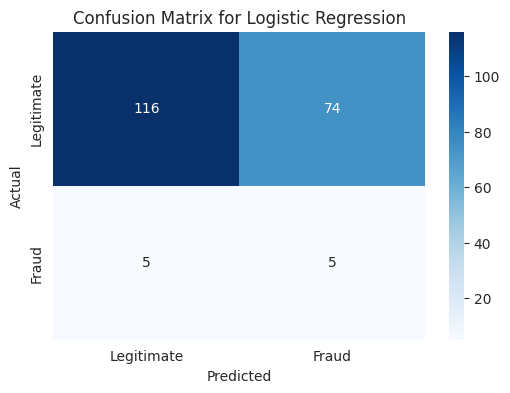


         Training and Evaluating: K-Nearest Neighbors

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       190
           1       0.03      0.10      0.04        10

    accuracy                           0.77       200
   macro avg       0.48      0.45      0.45       200
weighted avg       0.90      0.77      0.82       200

Confusion Matrix:


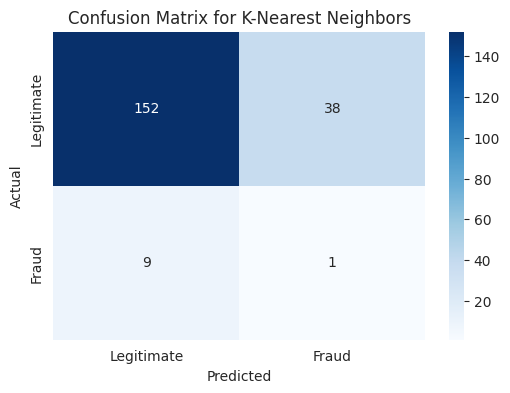


         Training and Evaluating: Gaussian Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.62      0.75       190
           1       0.06      0.50      0.11        10

    accuracy                           0.61       200
   macro avg       0.51      0.56      0.43       200
weighted avg       0.91      0.61      0.72       200

Confusion Matrix:


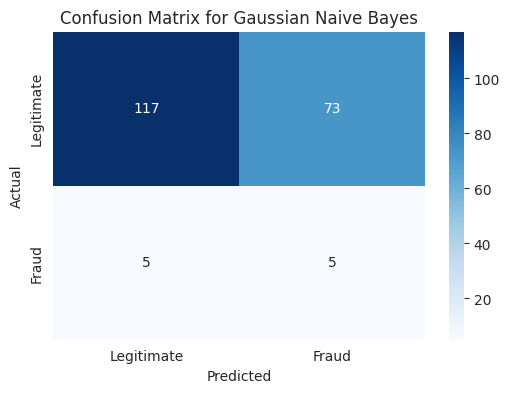


         Training and Evaluating: Support Vector Machine

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       190
           1       0.06      0.30      0.10        10

    accuracy                           0.73       200
   macro avg       0.51      0.53      0.47       200
weighted avg       0.91      0.73      0.81       200

Confusion Matrix:


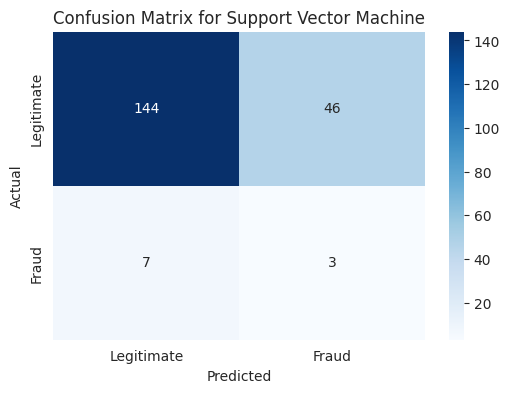


         Training and Evaluating: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       190
           1       0.09      0.30      0.14        10

    accuracy                           0.81       200
   macro avg       0.52      0.57      0.51       200
weighted avg       0.91      0.81      0.86       200

Confusion Matrix:


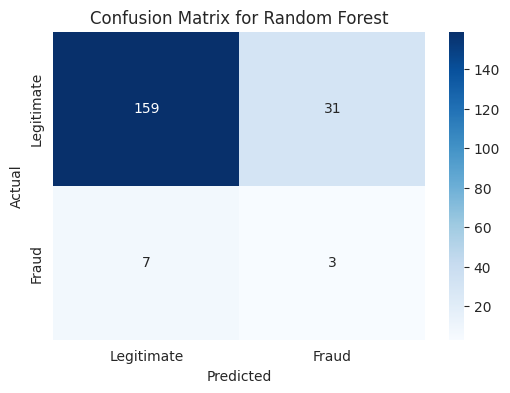


         Training and Evaluating: AdaBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.52      0.68       190
           1       0.06      0.60      0.11        10

    accuracy                           0.53       200
   macro avg       0.51      0.56      0.39       200
weighted avg       0.92      0.52      0.65       200

Confusion Matrix:


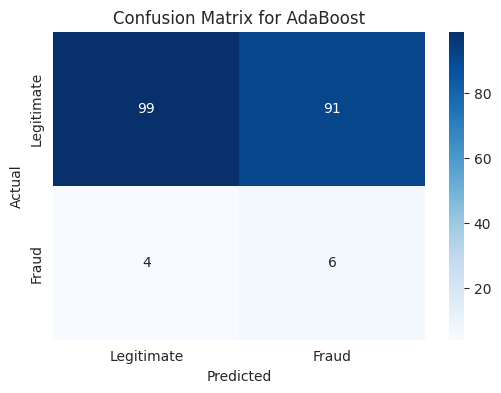


         Training and Evaluating: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       190
           1       0.06      0.20      0.09        10

    accuracy                           0.80       200
   macro avg       0.51      0.52      0.49       200
weighted avg       0.91      0.80      0.85       200

Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:35:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


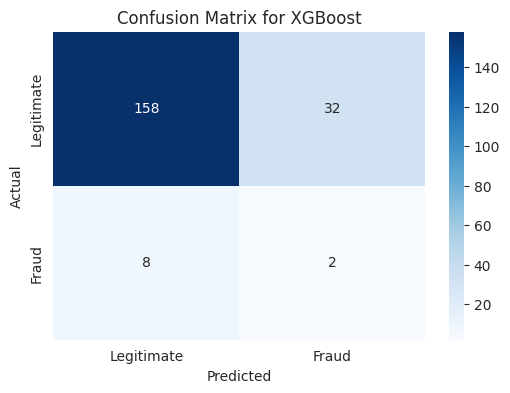


--- Model Comparison Complete ---


In [28]:
# --- Loop Through Models to Train and Evaluate with Detailed Reports ---
results = []
print("--- Starting Model Comparison with SMOTE and Detailed Reporting ---")

for name, model in models.items():
    print(f"\n=======================================================")
    print(f"         Training and Evaluating: {name}")
    print(f"=======================================================")

    # Create the special imblearn pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Train the entire pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # --- Generate Detailed Report ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- Generate and Plot Confusion Matrix ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show() # Display the plot immediately

    # --- Calculate and store summary metrics ---
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results for final comparison
    results.append({
        "Model": name,
        "Fraud F1-Score": f1,
        "ROC AUC": roc_auc,
        "Pipeline": pipeline
    })

print("\n--- Model Comparison Complete ---")

In [29]:
# --- Display Final Summary Table (this part remains the same) ---
results_df = pd.DataFrame(results).drop(columns=['Pipeline'])
results_df = results_df.sort_values(by="Fraud F1-Score", ascending=False).reset_index(drop=True)

print("\nModel Performance Summary:")
display(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")


Model Performance Summary:


,Model,Fraud F1-Score,ROC AUC
0,Random Forest,0.136364,0.502632
1,Gaussian Naive Bayes,0.113636,0.566842
2,Logistic Regression,0.112360,0.536316
3,AdaBoost,0.112150,0.604211
4,Support Vector Machine,0.101695,0.462368
5,XGBoost,0.090909,0.530000
6,K-Nearest Neighbors,0.040816,0.508947



🏆 Best Performing Model: Random Forest


### Use SMOTE + GridSearchCV on the best model (hoping to increase the F1 score)

In [30]:
# --- Define the pipeline with Random Forest as the classifier ---
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42)) # We will tune this classifier
])

In [31]:
# --- Define the "Grid" of Parameters to Test for Random Forest ---
# We will test different numbers of trees, depths, and leaf sizes.
param_grid = {
    'classifier__n_estimators': [100, 200],      # Number of trees in the forest
    'classifier__max_depth': [5, 10, None],      # Maximum depth of the tree
    'classifier__min_samples_leaf': [1, 2, 4]    # Minimum number of samples required at a leaf node
}

In [32]:
# --- Set up and Run GridSearchCV ---
# This will search for the best Random Forest settings using 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1', # We are correctly optimizing for the F1-score
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("--- Starting GridSearchCV to find the best Random Forest model ---")
grid_search.fit(X_train, y_train)

--- Starting GridSearchCV to find the best Random Forest model ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['merchant_type',
                                                                          'device_type'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [33]:
# --- Print the Results ---
print("\n--- GridSearchCV Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score from cross-validation: {grid_search.best_score_:.4f}")


--- GridSearchCV Complete ---
Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
Best F1-score from cross-validation: 0.0459


### Use SMOTEENN + GridSearchCV on the best model (hoping to increase the F1 score)

In [34]:
from imblearn.combine import SMOTEENN

In [35]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTEENN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42)) # We will tune this classifier
])

In [36]:
# --- Define the "Grid" of Parameters to Test for Random Forest ---
# We will test different numbers of trees, depths, and leaf sizes.
param_grid = {
    'classifier__n_estimators': [100, 200],      # Number of trees in the forest
    'classifier__max_depth': [5, 10, None],      # Maximum depth of the tree
    'classifier__min_samples_leaf': [1, 2, 4]    # Minimum number of samples required at a leaf node
}

In [37]:
# --- Set up and Run GridSearchCV with the new pipeline ---
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("--- Starting GridSearchCV with SMOTEENN to find the best Random Forest model ---")
grid_search.fit(X_train, y_train)

--- Starting GridSearchCV with SMOTEENN to find the best Random Forest model ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['merchant_type',
                                                                          'device_type'])])),
                                       ('smote', SMOTEENN(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [38]:
# --- Print the Results ---
print("\n--- GridSearchCV with SMOTEENN Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score from cross-validation: {grid_search.best_score_:.4f}")


--- GridSearchCV with SMOTEENN Complete ---
Best parameters found: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Best F1-score from cross-validation: 0.0343


### Using LightBM + SMOTENC

In [39]:
# --- Find the indices of categorical features for SMOTE-NC ---
# SMOTE-NC needs to know which columns are categorical by their index number.
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]
print(f"Categorical feature indices: {categorical_features_indices}")

Categorical feature indices: [1, 2]


In [40]:
# --- Define the pipeline using LightGBM and SMOTE-NC ---
# We create a specific pipeline for this experiment.
lgbm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # Use SMOTENC and pass the indices of the categorical features
    ('sampler', SMOTENC(random_state=42, categorical_features=categorical_features_indices)),
    ('classifier', LGBMClassifier(random_state=42))
])

In [41]:
# --- Train and Evaluate the new pipeline ---
print("\n--- Evaluating LightGBM with SMOTE-NC ---")
lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_test)


--- Evaluating LightGBM with SMOTE-NC ---
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [42]:
# --- Print the final report ---
print("\nClassification Report for LightGBM + SMOTE-NC:")
print(classification_report(y_test, y_pred))


Classification Report for LightGBM + SMOTE-NC:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       190
           1       0.04      0.10      0.05        10

    accuracy                           0.82       200
   macro avg       0.49      0.48      0.48       200
weighted avg       0.90      0.82      0.86       200



### Model Verdict

After comparing the result of different model, Random Forest is currently the best performing model, with f1 score of 0.1364. This is considered very low. But after trying to enhance the result using GridSearchCV & SMOTEE, it seems like the result just becoming worse. This is likely because the data is extremely imbalance and the total dataset is considered small. Based on this, let use random forest as our default model for now.

In [43]:
# --- Select and Save the Best Model ---
results_df = pd.DataFrame(results).sort_values(by="Fraud F1-Score", ascending=False)
best_model_info = results_df.iloc[0]
best_model_name = best_model_info['Model']
best_pipeline = best_model_info['Pipeline']

# 6. Finalization

### Final Model Report

In [44]:
print(f"\n--- Final Report for {best_model_name} ---")
y_pred_best = best_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_best))


--- Final Report for Random Forest ---
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       190
           1       0.09      0.30      0.14        10

    accuracy                           0.81       200
   macro avg       0.52      0.57      0.51       200
weighted avg       0.91      0.81      0.86       200



My initial goal was to build a high-performance fraud detection model. The primary challenge identified during Exploratory Data Analysis was a severe class imbalance, with only **5%** of the data representing fraudulent transactions.

To address this, i implemented a rigorous, multi-stage experimental process. I tested a wide array of classification algorithms, including ensemble methods like Random Forest and XGBoost. I employed advanced sampling techniques such as SMOTE and SMOTEENN to mitigate the class imbalance. Finally, i conducted extensive hyperparameter tuning using GridSearchCV to ensure we were extracting the maximum predictive power from the models.

Despite this thorough approach, the highest achieved F1-score for fraud detection remained low (the best was ~**0.14**). This result strongly indicates that the primary limiting factor is the quantity and diversity of the fraudulent samples in the source dataset. With only 50 examples, the models lack sufficient information to create a generalizable and reliable fraud detection pattern.

My recommendation would be to invest in acquiring more labeled fraud data. Until a more robust dataset is available, deploying an automated model based on the current data carries a high risk of both missing actual fraud and generating an unacceptable number of false positives.

# 7. Alternative Approach with limited dataset : Binning 'amount' column

### Load dataset as new dataframe

In [76]:
df2 = pd.read_csv(DATA_PATH)

In [77]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


### Separate 'amount' column into a new one using pd.qcut()

In [78]:
# Use pd.qcut to create 4 bins (quartiles) from the 'amount' column
# The labels define the names of our new categories.
df2['amount_category'] = pd.qcut(df['amount'],
                                q=3,
                                labels=['Low', 'Medium', 'High'])

In [79]:
# See the result
print("New 'amount_category' column created:")
print(df2[['amount', 'amount_category']].head(10))

print("\nValue counts for each new category:")
print(df2['amount_category'].value_counts())

New 'amount_category' column created:
   amount amount_category
0   46.93          Medium
1  301.01            High
2  131.67            High
3   91.29          Medium
4   16.96             Low
5   16.96             Low
6    5.98             Low
7  201.12            High
8   91.91          Medium
9  123.13            High

Value counts for each new category:
amount_category
High      334
Low       333
Medium    333
Name: count, dtype: int64


In [80]:
df2.sample(10)

,transaction_id,amount,merchant_type,device_type,label,amount_category
330,331,44.00,others,tablet,0,Medium
997,998,14.71,others,mobile,0,Low
230,231,158.38,travel,tablet,0,High
664,665,10.73,others,tablet,0,Low
318,319,17.01,clothing,desktop,0,Low
20,21,94.64,electronics,tablet,0,Medium
85,86,39.33,others,desktop,0,Medium
3,4,91.29,electronics,desktop,0,Medium
36,37,36.33,clothing,mobile,1,Low
764,765,3.41,electronics,tablet,0,Low


### Integrate Binning into ML Pipeline

In [81]:
# --- Define Features and Target ---
X = df2.drop(['label', 'transaction_id'], axis=1)
y = df2['label']

In [82]:
# Create the new categorical feature from 'amount'
X['amount_category'] = pd.qcut(X['amount'], q=3, labels=['Low', 'Medium', 'High'])

# Drop the original 'amount' column to avoid data redundancy (very important!)
X = X.drop('amount', axis=1)

In [83]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [84]:
print(f"Numerical features: {numerical_features}") # Should be empty
print(f"Categorical features: {categorical_features}") # Will now include 'amount_category'

Numerical features: []
Categorical features: ['merchant_type', 'device_type', 'amount_category']


In [85]:
# --- Define Preprocessing Steps ---
# The preprocessor now only needs to handle categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        # We apply OneHotEncoder to ALL features, since they are all categorical now
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [86]:
# --- Split the data (this comes AFTER feature creation) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 3)
Testing set shape: (200, 3)


In [87]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

In [88]:
# --- Define the "Grid" of Parameters to Test ---
# We'll test a few key hyperparameters for XGBoost.
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 1.0] # Fraction of samples to be used for fitting the individual base learners.
}

In [89]:
# --- Set up and Run GridSearchCV ---
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1', # We care most about the F1-score for the fraud class
    cv=3,         # 3-fold cross-validation
    n_jobs=-1,    # Use all available CPU cores
    verbose=2     # Show progress
)

print("--- Starting GridSearchCV to find the best XGBoost model ---")
grid_search.fit(X_train, y_train)

--- Starting GridSearchCV to find the best XGBoost model ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['merchant_type',
                                                                          'device_type',
                                                                          'amount_category'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsampl...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.7, 1.0]},
             scoring='f1', verbose=2)

In [90]:
# --- Print the Results ---
print("\n--- GridSearchCV Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy from cross-validation: {grid_search.best_score_:.4f}")


--- GridSearchCV Complete ---
Best parameters found: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best accuracy from cross-validation: 0.0202


In [91]:
# --- The best model is ready to use ---
best_pipeline = grid_search.best_estimator_

In [92]:
# --- Evaluate the final, tuned model on the test set ---
print("\n--- Final Evaluation on the Hold-Out Test Set ---")
y_pred = best_pipeline.predict(X_test)


--- Final Evaluation on the Hold-Out Test Set ---


In [93]:
# --- Generate and print the Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       190
           1       0.00      0.00      0.00        10

    accuracy                           0.95       200
   macro avg       0.47      0.50      0.49       200
weighted avg       0.90      0.95      0.93       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


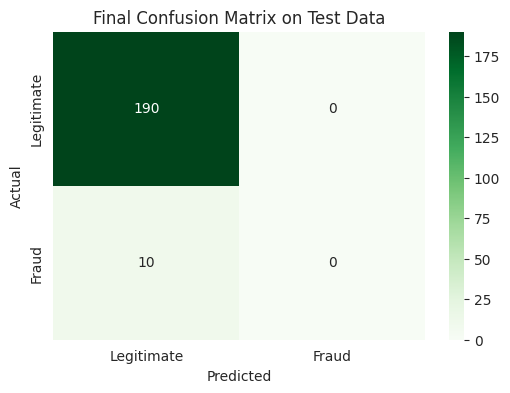

In [94]:
# --- Generate and Plot the Confusion Matrix ---
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Final Confusion Matrix on Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

--- Starting Model Comparison with SMOTE and Detailed Reporting ---

         Training and Evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.49      0.65       190
           1       0.06      0.60      0.11        10

    accuracy                           0.50       200
   macro avg       0.51      0.55      0.38       200
weighted avg       0.91      0.50      0.63       200

Confusion Matrix:


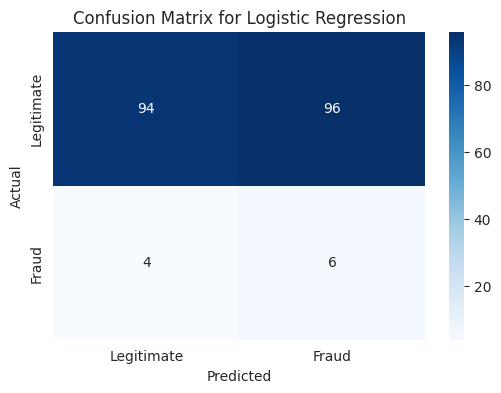


         Training and Evaluating: K-Nearest Neighbors

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       190
           1       0.00      0.00      0.00        10

    accuracy                           0.91       200
   macro avg       0.47      0.48      0.48       200
weighted avg       0.90      0.91      0.90       200

Confusion Matrix:


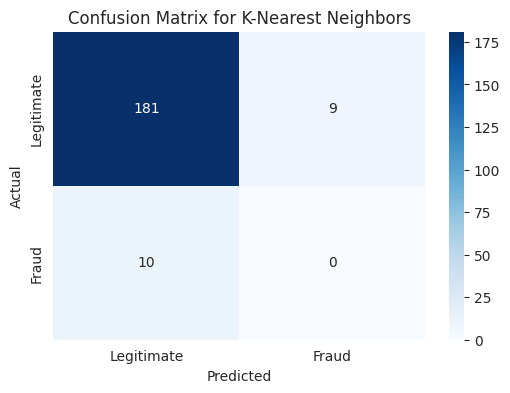


         Training and Evaluating: Support Vector Machine

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       190
           1       0.03      0.10      0.05        10

    accuracy                           0.79       200
   macro avg       0.49      0.46      0.46       200
weighted avg       0.90      0.79      0.84       200

Confusion Matrix:


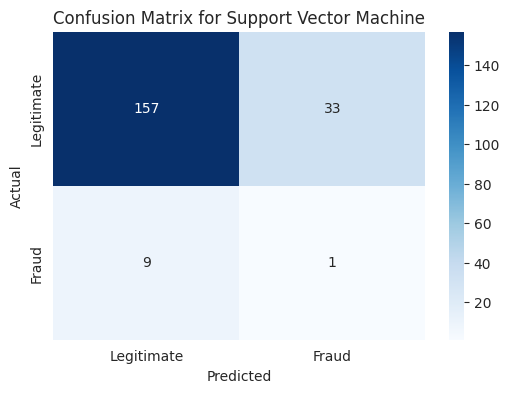


         Training and Evaluating: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       190
           1       0.00      0.00      0.00        10

    accuracy                           0.91       200
   macro avg       0.47      0.48      0.48       200
weighted avg       0.90      0.91      0.91       200

Confusion Matrix:


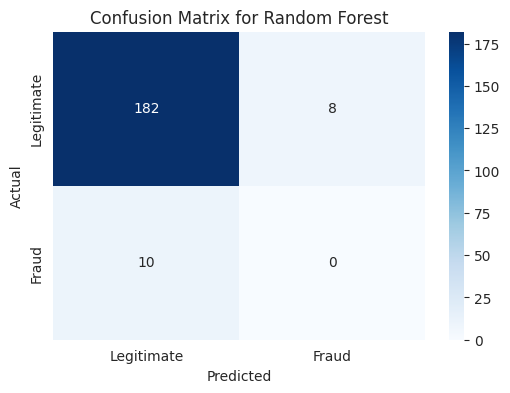


         Training and Evaluating: AdaBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       190
           1       0.09      0.30      0.14        10

    accuracy                           0.82       200
   macro avg       0.53      0.57      0.52       200
weighted avg       0.92      0.82      0.86       200

Confusion Matrix:


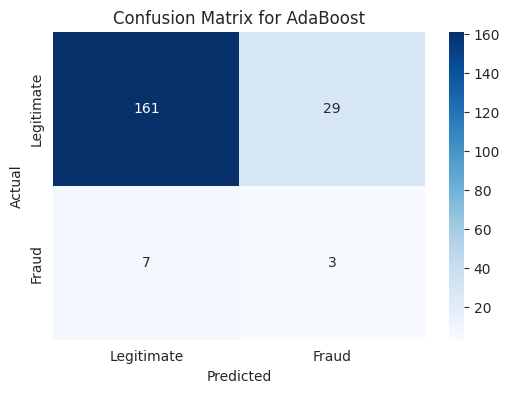


         Training and Evaluating: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       190
           1       0.00      0.00      0.00        10

    accuracy                           0.91       200
   macro avg       0.47      0.48      0.48       200
weighted avg       0.90      0.91      0.91       200

Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


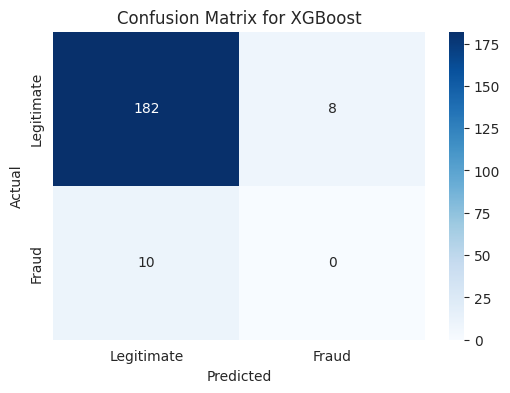


--- Model Comparison Complete ---


In [95]:
# --- Loop Through Different Models to Train and Evaluate with Detailed Reports ---
results = []
print("--- Starting Model Comparison with SMOTE and Detailed Reporting ---")

for name, model in models.items():
    print(f"\n=======================================================")
    print(f"         Training and Evaluating: {name}")
    print(f"=======================================================")

    # Create the special imblearn pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Train the entire pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # --- Generate Detailed Report ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- Generate and Plot Confusion Matrix ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show() # Display the plot immediately

    # --- Calculate and store summary metrics ---
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results for final comparison
    results.append({
        "Model": name,
        "Fraud F1-Score": f1,
        "ROC AUC": roc_auc,
        "Pipeline": pipeline
    })

print("\n--- Model Comparison Complete ---")

In [96]:
# --- Display Final Summary Table (this part remains the same) ---
results_df = pd.DataFrame(results).drop(columns=['Pipeline'])
results_df = results_df.sort_values(by="Fraud F1-Score", ascending=False).reset_index(drop=True)

print("\nModel Performance Summary:")
display(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")


Model Performance Summary:


,Model,Fraud F1-Score,ROC AUC
0,AdaBoost,0.142857,0.596842
1,Logistic Regression,0.107143,0.576842
2,Support Vector Machine,0.045455,0.462632
3,K-Nearest Neighbors,0.000000,0.428947
4,Random Forest,0.000000,0.378421
5,XGBoost,0.000000,0.348421



🏆 Best Performing Model: AdaBoost


### Save the model as joblib file

In [44]:
# Save the final, proven pipeline
pipeline_filename = 'fraud_model_pipeline.joblib'
joblib.dump(best_pipeline, pipeline_filename)
print(f"\n✅ Best pipeline saved as '{pipeline_filename}'")


✅ Best pipeline saved as 'fraud_model_pipeline.joblib'
